In [ ]:
!pip install geopandas
!pip install pysal
!pip install esda
!pip install spreg
!pip install splot

## Análisis de la Correlación o Dependencia Espacial: Modelos de regresión espacial

Además de `geopandas`para representar mapas, utilizaremos el paquete `spreg`  y  `weights` incluidos dentro del macro-proyecto `PySAL`

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import warnings

# puedo instalar toda la meta-librería pysal (Ojo que tarda)
# conda install --channel conda-forge pysal

# from pysal.lib import weights  # Para Construir la matriz de pesos espaciales
# from pysal.explore import esda  # Exploratory Spatial analytics
# from pysal.model import spreg   # Para los modelos de regresion espacial
# from pysal.viz import splot   # para conectar los análisis espaciales hechos en PySAL con herramientas de visaluización como matplotly


# O puedo instalar solo los paquetes que me interesan del metaproyecto pysal
# conda install --channel conda-forge libpysal
# conda install --channel conda-forge esda
# conda install --channel conda-forge spreg
# conda install --channel conda-forge splot

from libpysal import weights
import esda
import spreg


from splot import esda as esdaplot
from splot.esda import plot_moran    # para los gráficos de Moran



## Objetivo de la práctica: La Ley de Okun
Queremos estimar la ley de OKUN con datos Municipales, en este caso para explicar la Tasa de Paro Municipal en función de la renta percápita Municipal. Al tener datos georeferenciados nos preguntaremos si en la explicación de la tasa de paro municipal existen correlaciones espaciales con los municipio vecinos, y en tal caso presentaremos dos modelos para intentar estimar dichos efectos espaciales

### Cargamos la cartografía

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gdfm = gpd.read_file('/content/drive/MyDrive/Documentos/MASTER UCM/Colab Notebooks/espacial/Munic04_ESP.shp')
gdfm.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8108 entries, 0 to 8107
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SP_ID       8108 non-null   object  
 1   id          8108 non-null   object  
 2   cod_ine     8108 non-null   object  
 3   CODINE_MU   8108 non-null   object  
 4   CCAA        8108 non-null   object  
 5   COD_PROV    8108 non-null   object  
 6   PROV        8108 non-null   object  
 7   MUN         8108 non-null   object  
 8   POB_2016    8108 non-null   float64 
 9   POB_HO      8108 non-null   float64 
 10  POB_MU      8108 non-null   float64 
 11  PARO_TO     8108 non-null   float64 
 12  POB16_64    8108 non-null   float64 
 13  TASA_PARO   8108 non-null   float64 
 14  RENTPCAP07  8108 non-null   float64 
 15  PrecioIn16  8108 non-null   float64 
 16  geometry    8108 non-null   geometry
dtypes: float64(8), geometry(1), object(8)
memory usage: 1.1+ MB


In [31]:
gdfm_Madrid =gdfm[gdfm['COD_PROV']=='28']


gdfm_Madrid.explore(column='PrecioIn16',
                   scheme='NaturalBreaks',
                   k=9, cmap='YlOrRd',
                   legend=False,
                   style_kwds=dict(fillOpacity=0.8))

In [33]:
gdfm_Madrid.sort_values('PrecioIn16', ascending=False)


SP_ID     id cod_ine CODINE_MU                  CCAA COD_PROV    PROV  \
4351  28079  28079   28079     28079  Madrid, Comunidad de       28  Madrid   
4279  28006  28006   28006     28006  Madrid, Comunidad de       28  Madrid   
4383  28115  28115   28115     28115  Madrid, Comunidad de       28  Madrid   
4352  28080  28080   28080     28080  Madrid, Comunidad de       28  Madrid   
4452  28903  28903   28903     28903  Madrid, Comunidad de       28  Madrid   
...     ...    ...     ...       ...                   ...      ...     ...   
4333  28060  28060   28060     28060  Madrid, Comunidad de       28  Madrid   
4385  28117  28117   28117     28117  Madrid, Comunidad de       28  Madrid   
4421  28155  28155   28155     28155  Madrid, Comunidad de       28  Madrid   
4342  28069  28069   28069     28069  Madrid, Comunidad de       28  Madrid   
4312  28039  28039   28039     28039  Madrid, Comunidad de       28  Madrid   

                      MUN   POB_2016     POB_HO     POB_MU    PARO_TO  \
4351               Madrid  3165541.0  1472172.0  1693369.0  218269.83   
4279           Alcobendas   113340.0    54631.0    58709.0    6740.08   
4383   Pozuelo de Alarcón    84989.0    40722.0    44267.0    3077.00   
4352          Majadahonda    70755.0    33619.0    37136.0    3145.16   
4452          Tres Cantos    44764.0    21764.0    23000.0    1985.83   
...                   ...        ...        ...        ...        ...   
4333  Fuentidueña de Tajo     1936.0      963.0      973.0     251.16   
4385   Prádena del Rincón      134.0       75.0       59.0       5.58   
4421          Valdaracete      641.0      330.0      311.0      81.50   
4342          Hiruela, La       54.0       36.0       18.0       0.00   
4312  Cervera de Buitrago      157.0       91.0       66.0      12.58   

       POB16_64  TASA_PARO  RENTPCAP07  PrecioIn16  \
4351  2068948.0   0.105498    40790.05     2923.46   
4279    77637.0   0.086815    38525.45     2906.00   
4383    56215.0   0.054736    34622.85     2574.32   
4352    47451.0   0.066282    34069.24     2495.02   
4452    31347.0   0.063350    30109.14     2242.06   
...         ...        ...         ...         ...   
4333     1353.0   0.185632    14051.59      965.00   
4385       73.0   0.076438    13458.13      944.61   
4421      414.0   0.196860    13511.97      927.94   
4342       34.0   0.000000    12998.57      912.35   
4312       95.0   0.132421    12431.60      872.56   

                                               geometry  
4351  POLYGON ((-3.66733 40.62944, -3.66656 40.63187...  
4279  POLYGON ((-3.69119 40.58211, -3.67299 40.59084...  
4383  POLYGON ((-3.86061 40.44202, -3.86144 40.44587...  
4352  POLYGON ((-3.93397 40.50016, -3.93207 40.50141...  
4452  POLYGON ((-3.66774 40.63204, -3.66656 40.63187...  
...                                                 ...  
4333  POLYGON ((-3.15739 40.15778, -3.14908 40.16307...  
4385  POLYGON ((-3.54581 41.04830, -3.54110 41.05256...  
4421  POLYGON ((-3.17676 40.23797, -3.17190 40.23590...  
4342  POLYGON ((-3.47789 41.06922, -3.48380 41.06591...  
4312  POLYGON ((-3.54095 40.92269, -3.54880 40.92351...  

[179 rows x 17 columns]

Comenzamos Analizando los datos de Renta Per cápita

In [5]:
gdfm[["MUN","RENTPCAP07"]].sort_values(by='RENTPCAP07',ascending=False).head(15)



MUN  RENTPCAP07
4351                  Madrid    40790.05
878                Barcelona    40178.55
3193  Donostia/San Sebastián    39290.65
3203                 Zarautz    39242.60
810                     Deyá    38578.88
4279              Alcobendas    38525.45
1127                  Sitges    37308.56
1078       Sant Just Desvern    35678.56
3163                 Getaria    34974.35
1062   Sant Cugat del Vallès    34961.38
4383      Pozuelo de Alarcón    34622.85
7498                   Getxo    34542.66
3160             Hondarribia    34330.58
4352             Majadahonda    34069.24
936   Esplugues de Llobregat    33695.28

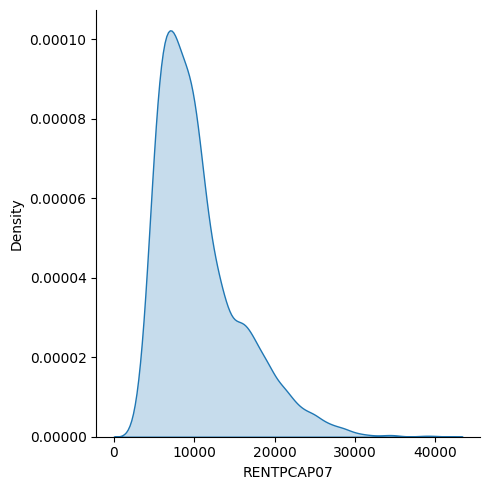

In [6]:
sns.displot(x=gdfm.RENTPCAP07, kind="kde", fill=True)
plt.show()

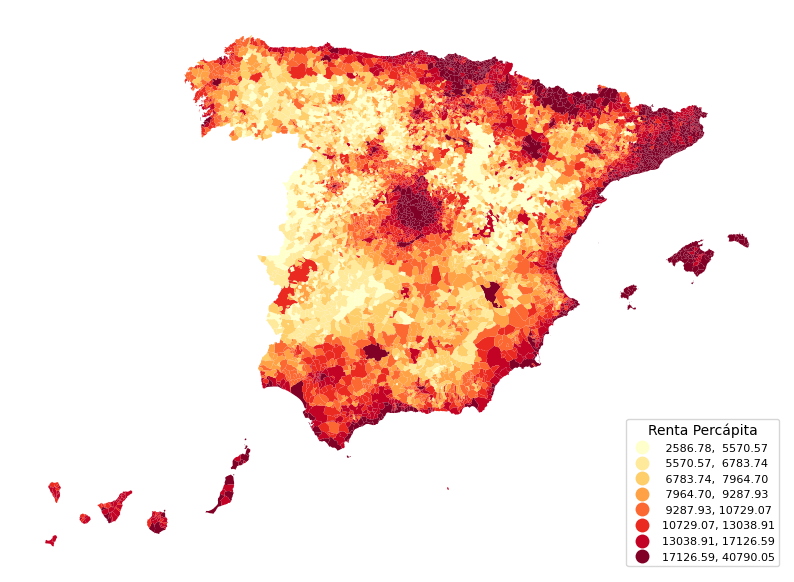

In [7]:
map=gdfm.plot(column='RENTPCAP07',
         scheme='quantiles',
         k=8, cmap='YlOrRd',
         legend=True,
         figsize=(10,10),
         legend_kwds={'loc': 'lower right', 'fontsize':'8', 'title':'Renta Percápita'}
)
map.set_axis_off()

Nuestra Variable dependiente (Variable Objetivo) es la **tasa de desempleo municipal**

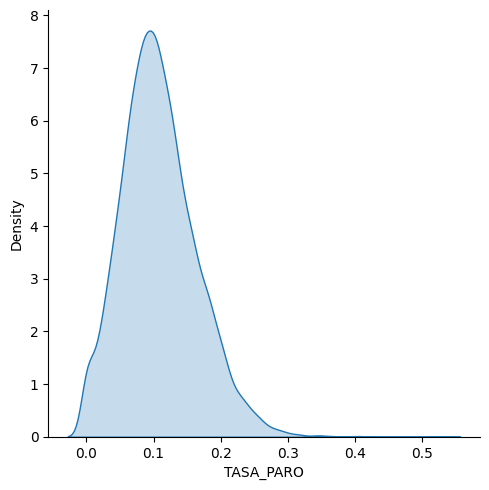

In [8]:
sns.displot(x=gdfm.TASA_PARO, kind="kde", fill=True)
plt.show()

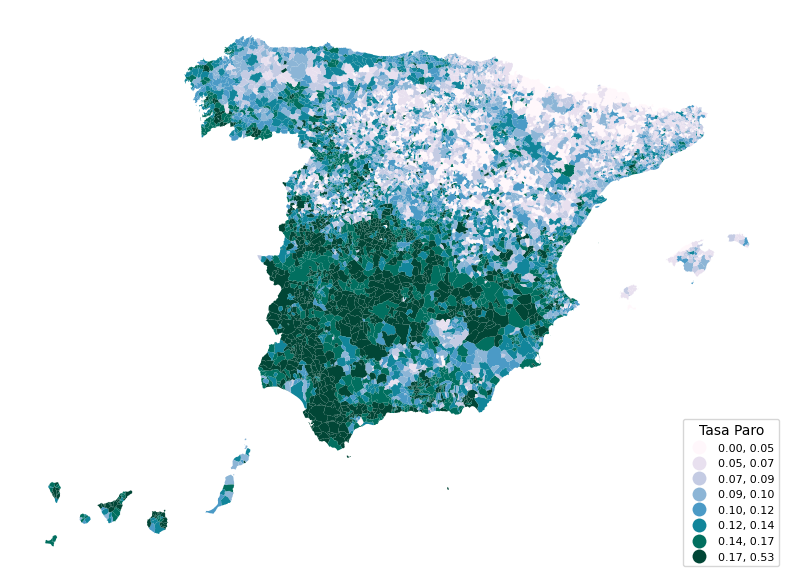

In [9]:
map=gdfm.plot(column='TASA_PARO',
         scheme='quantiles',
         k=8, cmap='PuBuGn',
         legend=True,
         figsize=(10,10),
         legend_kwds={'loc': 'lower right', 'fontsize':'8', 'title':'Tasa Paro'}
)
map.set_axis_off()

plt.savefig('Tasa_paro.jpg')

## Construcción de la Matriz de Pesos

Las matrices de pesos o de importancias espaciales pueden construirse por vecindad-contigüidad o por distancia

### Matrices de pesos por contigüidad

In [10]:
# Matriz de pesos por vecindad tipo torre
wr = weights.contiguity.Rook.from_dataframe(gdfm)


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  warnings.warn(message)


In [11]:
print(wr.n)

8108


In [12]:
wr.neighbors

{0: [16, 19, 38, 27, 9, 11],
 1: [1317, 39, 7, 7528, 7529, 15, 48, 1210],
 2: [3137, 7526, 43, 3179, 3158, 3192, 7545, 7486, 7455],
 3: [7496, 1478, 7],
 4: [1257, 34, 10],
 5: [16, 3192, 43, 44, 13],
 6: [36, 38, 4670, 41, 3149, 46, 3183],
 7: [1, 3, 1541, 1478, 7528, 7496, 7529, 26, 30],
 8: [4033, 37, 4168, 42, 4078, 17, 4180, 4157],
 9: [0, 3137, 36, 38, 44, 3183, 16, 19, 3158, 3192],
 10: [34, 4, 1257, 1339, 47],
 11: [0, 4738, 4713, 1257, 12, 44, 14, 16, 19, 4660, 21, 22, 4759, 27],
 12: [4736, 4640, 4713, 41, 4779, 11, 4861, 4826, 27, 4605],
 13: [48, 5, 7478, 7542, 43, 44],
 14: [4738, 18, 22, 23, 11],
 15: [1, 33, 39, 40, 44, 48, 49, 1210],
 16: [0, 19, 5, 3192, 9, 11, 44],
 17: [4096, 22, 8, 42, 29, 4078],
 18: [14, 22, 23],
 19: [0, 36, 38, 9, 11, 44, 16, 27],
 20: [32, 4065, 4066, 4100, 4103, 4168, 47, 1339],
 21: [32, 37, 22, 1257, 11],
 22: [4096, 4738, 37, 11, 14, 17, 18, 21, 23, 4120, 24, 29, 25, 31],
 23: [18, 22, 4120, 45, 14, 31],
 24: [4096, 22],
 25: [42, 29, 37, 2

In [13]:
# Representación de la matriz de contiguidades:

pd.DataFrame(*wr.full()).astype(int)

0     1     2     3     4     5     6     7     8     9     ...  8098  \
0        0     0     0     0     0     0     0     0     0     1  ...     0   
1        0     0     0     0     0     0     0     1     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     1     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
8103     0     0     0     0     0     0     0     0     0     0  ...     0   
8104     0     0     0     0     0     0     0     0     0     0  ...     0   
8105     0     0     0     0     0     0     0     0     0     0  ...     0   
8106     0     0     0     0     0     0     0     0     0     0  ...     0   
8107     0     0     0     0     0     0     0     0     0     0  ...     0   

      8099  8100  8101  8102  8103  8104  8105  8106  8107  
0        0     0     0     0     0     0     0     0     0  
1        0     0     0     0     0     0     0     0     0  
2        0     0     0     0     0     0     0     0     0  
3        0     0     0     0     0     0     0     0     0  
4        0     0     0     0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
8103     0     0     0     1     0     0     0     0     0  
8104     0     0     0     0     0     0     0     0     0  
8105     0     0     0     0     0     0     0     0     0  
8106     0     0     0     0     0     0     0     0     0  
8107     0     0     0     0     0     0     0     0     0  

[8108 rows x 8108 columns]

In [14]:
print(wr.n**2)

print(wr.nonzero)

print(wr.nonzero/wr.n**2)
wr.pct_nonzero # % de nonzeros, es una medida de la densidad de 1

65739664
46814
0.0007121119450808267


0.07121119450808266

In [15]:
# Matriz de pesos por vecindad tipo reina
wq = weights.contiguity.Queen.from_dataframe(gdfm)


/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 19 disconnected components.
 There are 8 islands with ids: 816, 2536, 5326, 7061, 7160, 7229, 8106, 8107.
  warnings.warn(message)


In [16]:
wq.neighbors

{0: [16, 19, 38, 27, 9, 11],
 1: [1317, 39, 7, 7528, 7529, 15, 48, 1210],
 2: [3137, 7526, 43, 3179, 3158, 3192, 7545, 7486, 7455],
 3: [7496, 1478, 7],
 4: [1257, 34, 10],
 5: [16, 3192, 43, 44, 13],
 6: [4610, 36, 38, 41, 3149, 46, 3183, 4670],
 7: [1, 3, 1541, 1478, 1317, 7496, 7528, 7529, 26, 30],
 8: [4033, 37, 4168, 42, 4078, 17, 4180, 4157],
 9: [0, 3137, 36, 38, 44, 3183, 16, 19, 3158, 3192],
 10: [34, 4, 1257, 1339, 47],
 11: [0, 4738, 4713, 1257, 12, 44, 14, 16, 19, 4660, 21, 22, 4759, 27],
 12: [4736, 4640, 4713, 41, 11, 4779, 4861, 4826, 27, 4605],
 13: [48, 5, 7478, 7542, 43, 44],
 14: [4738, 18, 22, 23, 11, 45],
 15: [1, 33, 39, 40, 44, 48, 49, 1210],
 16: [0, 19, 5, 3192, 9, 11, 44],
 17: [4096, 22, 8, 42, 29, 4078],
 18: [14, 22, 23],
 19: [0, 36, 38, 9, 11, 44, 16, 27],
 20: [32, 4065, 4066, 4100, 4103, 4168, 47, 1339],
 21: [32, 4033, 37, 22, 1257, 11],
 22: [4096, 4738, 37, 11, 14, 17, 18, 21, 23, 4120, 24, 29, 25, 31],
 23: [4738, 18, 22, 4120, 45, 14, 31],
 24: [40

In [17]:
print(wq.n)

8108


In [18]:
wq.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [19]:
# Cardinal del número de vecinos para cada observación
wq.cardinalities

{0: 6,
 1: 8,
 2: 9,
 3: 3,
 4: 3,
 5: 5,
 6: 8,
 7: 10,
 8: 8,
 9: 10,
 10: 5,
 11: 14,
 12: 10,
 13: 6,
 14: 6,
 15: 8,
 16: 7,
 17: 6,
 18: 3,
 19: 8,
 20: 8,
 21: 6,
 22: 14,
 23: 7,
 24: 2,
 25: 4,
 26: 5,
 27: 7,
 28: 2,
 29: 4,
 30: 5,
 31: 9,
 32: 7,
 33: 8,
 34: 6,
 35: 3,
 36: 6,
 37: 7,
 38: 10,
 39: 4,
 40: 12,
 41: 9,
 42: 5,
 43: 6,
 44: 11,
 45: 4,
 46: 3,
 47: 5,
 48: 7,
 49: 5,
 50: 8,
 51: 4,
 52: 7,
 53: 16,
 54: 4,
 55: 5,
 56: 6,
 57: 8,
 58: 24,
 59: 9,
 60: 6,
 61: 6,
 62: 6,
 63: 5,
 64: 4,
 65: 4,
 66: 7,
 67: 7,
 68: 5,
 69: 10,
 70: 7,
 71: 6,
 72: 7,
 73: 7,
 74: 6,
 75: 3,
 76: 6,
 77: 4,
 78: 4,
 79: 12,
 80: 6,
 81: 5,
 82: 3,
 83: 7,
 84: 9,
 85: 4,
 86: 3,
 87: 11,
 88: 5,
 89: 7,
 90: 2,
 91: 8,
 92: 6,
 93: 7,
 94: 6,
 95: 6,
 96: 8,
 97: 4,
 98: 4,
 99: 7,
 100: 3,
 101: 7,
 102: 3,
 103: 4,
 104: 5,
 105: 6,
 106: 4,
 107: 5,
 108: 4,
 109: 8,
 110: 6,
 111: 3,
 112: 2,
 113: 6,
 114: 5,
 115: 5,
 116: 5,
 117: 8,
 118: 6,
 119: 13,
 120: 4,
 121: 4

In [20]:
wq.histogram

[(0, 8),
 (1, 60),
 (2, 199),
 (3, 557),
 (4, 1214),
 (5, 1744),
 (6, 1650),
 (7, 1116),
 (8, 683),
 (9, 379),
 (10, 194),
 (11, 106),
 (12, 63),
 (13, 41),
 (14, 24),
 (15, 17),
 (16, 15),
 (17, 7),
 (18, 6),
 (19, 4),
 (20, 3),
 (21, 3),
 (22, 2),
 (23, 1),
 (24, 3),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 0),
 (30, 0),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 0),
 (36, 0),
 (37, 0),
 (38, 0),
 (39, 1)]

In [21]:
pd.Series(wq.cardinalities).describe()


count    8108.000000
mean        5.964233
std         2.465742
min         0.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        39.000000
dtype: float64

<Axes: ylabel='Frequency'>

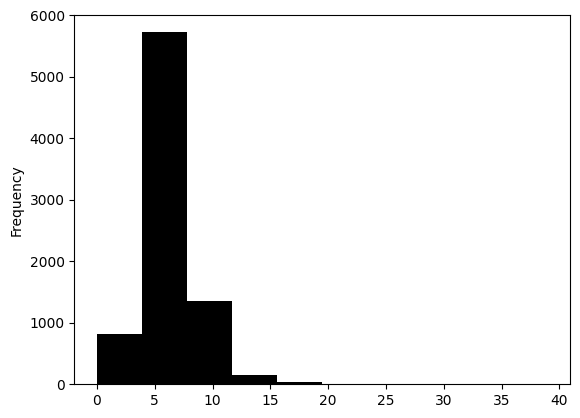

In [22]:
pd.Series(wq.cardinalities).plot.hist(color="k")

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x79ffbb18a050> (for post_execute):


KeyboardInterrupt: ignored

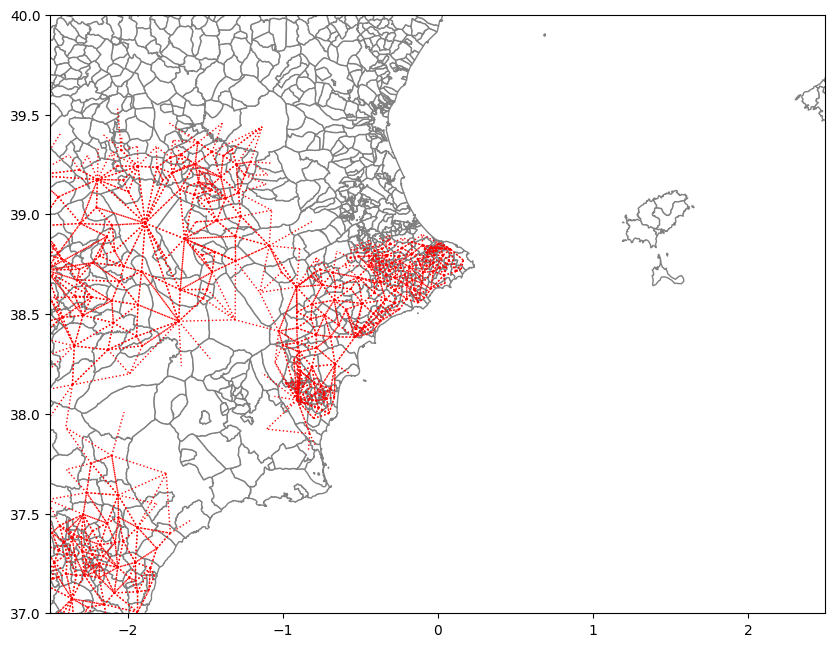

In [30]:
warnings.filterwarnings("ignore")  # Ignora todos los warnings

# Plot graph connections
ax = gdfm.plot(
    edgecolor="grey", facecolor="w",
    figsize=(10,10)
)
plt.xlim(-2.5,2.5)
plt.ylim(37,40)

wq.plot(
    gdfm,
    edge_kws=dict(color="r", linestyle=":", linewidth=1),
    node_kws=dict(marker=""),
    ax=ax
)

plt.show()




In [24]:
wq.islands

[816, 2536, 5326, 7061, 7160, 7229, 8106, 8107]

### Pesos Basados en Distancias
#### K-Nearest Neighbor weights

In [25]:
wk4 = weights.distance.KNN.from_dataframe(gdfm, k=4)

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


In [26]:
wk4.islands

[]

KeyboardInterrupt: ignored

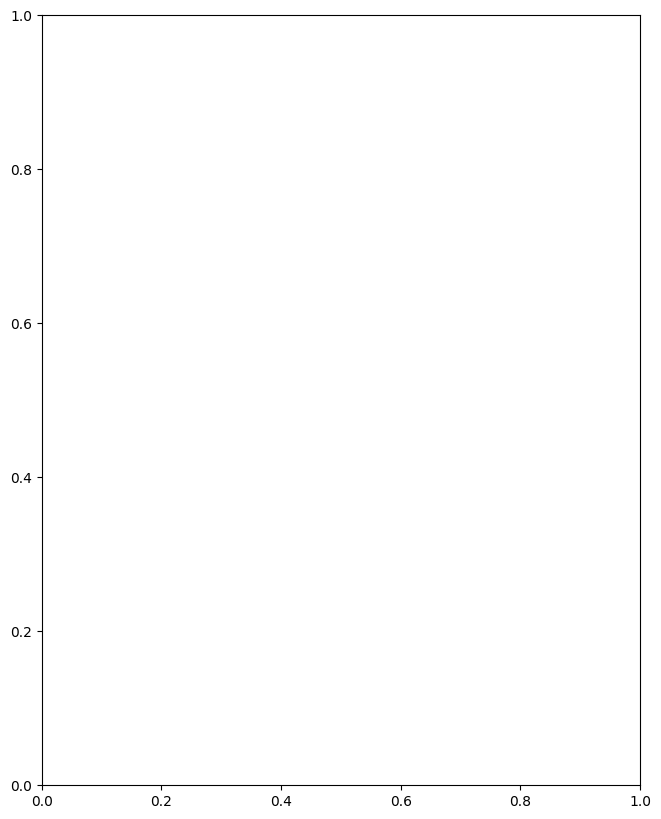

In [35]:
ax = gdfm.plot(
    edgecolor="grey", facecolor="w",
    figsize=(10,10)
)
plt.xlim(-2.5, 2.5)
plt.ylim(37, 40)

wk4.plot(
    gdfm,
    edge_kws={"linewidth": 1, "color": "orangered"},
    node_kws={"marker": "*"},
    ax=ax
)

plt.show()


### Kernel weights

Kernel weights son pesos inversamente proporcionales a la distancia. Reflejan la primera ley de Tobler, la importancia espacial tiende a caer con la distancia (afecta más lo más cercano)

In [36]:
# Kernel weights
w_kernel = weights.distance.Kernel.from_dataframe(gdfm)

KeyboardInterrupt: ignored

### Distance bands and hybrid Weights

La matriz de pesos ahora refleja el hecho de que sólo los vecinos próximos (los que están en un radio de x kms) tienen un peso positivo

In [46]:
w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdfm, 1.5, binary=True
)

El radio máximo también puede conjugarse con la importancia o peso inversamente proporcional a la distancia. Es como un Kernel Censurado, ya que la función kernel sólo se aplica a los vecinos próximos (dentro de un radio x)

In [48]:
w_hy = weights.distance.DistanceBand.from_dataframe(
    gdfm, 1.5, binary=False
)

KeyboardInterrupt: ignored

In [ ]:
w_hy.weights

Hay otras formas de calcular pesos, como por bloques. Tambien exista la posibilidad de unir dos o más matrices de pesos (y también se puede editar manualmente una matriz de pesos si fuese necesario)

In [49]:
w_bw = weights.util.block_weights(gdfm["CCAA"].values)
w_bw.weights

Output hidden; open in https://colab.research.google.com to view.

In [50]:
w_u = weights.set_operations.w_union(wq, wk4)
w_u.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 22: [1.0, 

In [51]:
w_u.islands

[]

## Retardos espaciales


Para poder utilizar la matriz de pesos espaciales como operador retardos necesitamos que estén normalizada por filas

In [52]:
wq.weights

{0: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 1: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 2: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 3: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 4: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 5: [0.2, 0.2, 0.2, 0.2, 0.2],
 6: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 8: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 9: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 10: [0.2, 0.2, 0.2, 0.2, 0.2],
 11: [0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142

In [53]:
# Transformar pesos por filas
wq.transform = "R"

In [54]:
w_u.transform = "R"

In [56]:
w_u.weights

{0: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 1: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 2: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 3: [0.2, 0.2, 0.2, 0.2, 0.2],
 4: [0.2, 0.2, 0.2, 0.2, 0.2],
 5: [0.2, 0.2, 0.2, 0.2, 0.2],
 6: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 8: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 9: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0

In [57]:
# Creación de variables con retardo espacial
gdfm["TASA_PARO_lag"] = weights.spatial_lag.lag_spatial(
    wq, gdfm["TASA_PARO"]
)


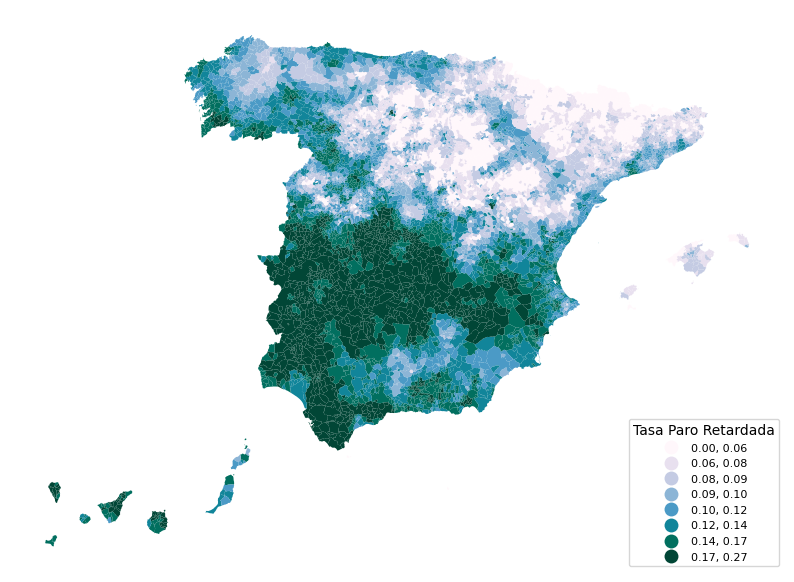

In [58]:
# representación de la tasa de paro retardada
map=gdfm.plot(column='TASA_PARO_lag',
         scheme='quantiles',
         k=8, cmap='PuBuGn',
         legend=True,
         figsize=(10,10),
         legend_kwds={'loc': 'lower right', 'fontsize':'8', 'title':'Tasa Paro Retardada'}
)
map.set_axis_off()

plt.savefig('Tasa_paro_lag.jpg')


## Autocorrelación Espacial

Tenemos ya dos variables para cada municipio: la Tasa de Paro del Municipio, y la Tasa de Paro media de los municipios cercanos/vecinos   
Ya podemos cuantificar la asosciación o correlación espacial analizando la correlación que existe entre estas dos variables


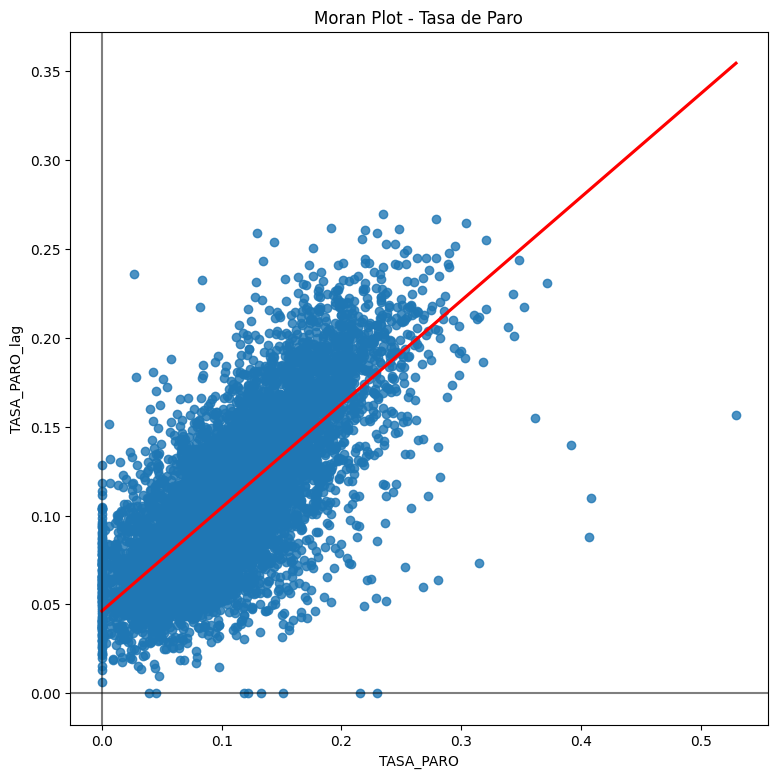

In [59]:
# AutoCorrelación Espacial
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(
    x="TASA_PARO",
    y="TASA_PARO_lag",
    ci=None,
    data=gdfm,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Tasa de Paro")
plt.show()

No puede utilizarse el coeficiente de correlación de person, porque hay que tener en cuenta los pesos espaciales. Debemos utilizar la I de Moran

In [60]:
# Correlación Espacial: La I de Moran
moran = esda.moran.Moran(gdfm["TASA_PARO"], wq)
print("I de moran:", moran.I.round(3))
print("p-valor:", moran.p_sim)

I de moran: 0.584
p-valor: 0.001


### Correlación Espacial Local

No todos lso Municipios tienen que presentar dependencia espacial con sus vecinos. PAra analizar qué municipios sí presentan y cuáles no, se utiliza la correlación espacial Local (LISA: Local Indicator of Spatial autocorrelation)

In [62]:
#Correlación Espacial Local
lisa = esda.moran.Moran_Local(gdfm["TASA_PARO"], wq)

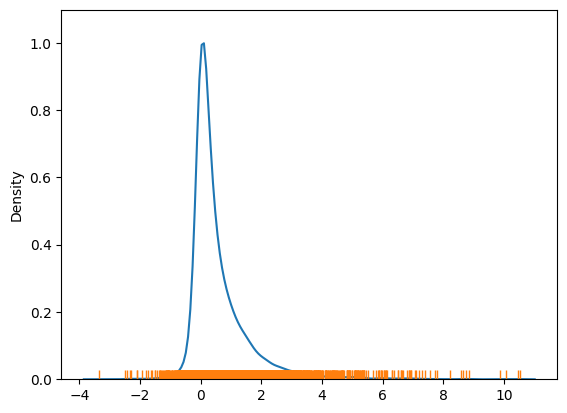

In [63]:
#Representación del Indice de Moran Local (Is)
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa.Is, ax=ax);

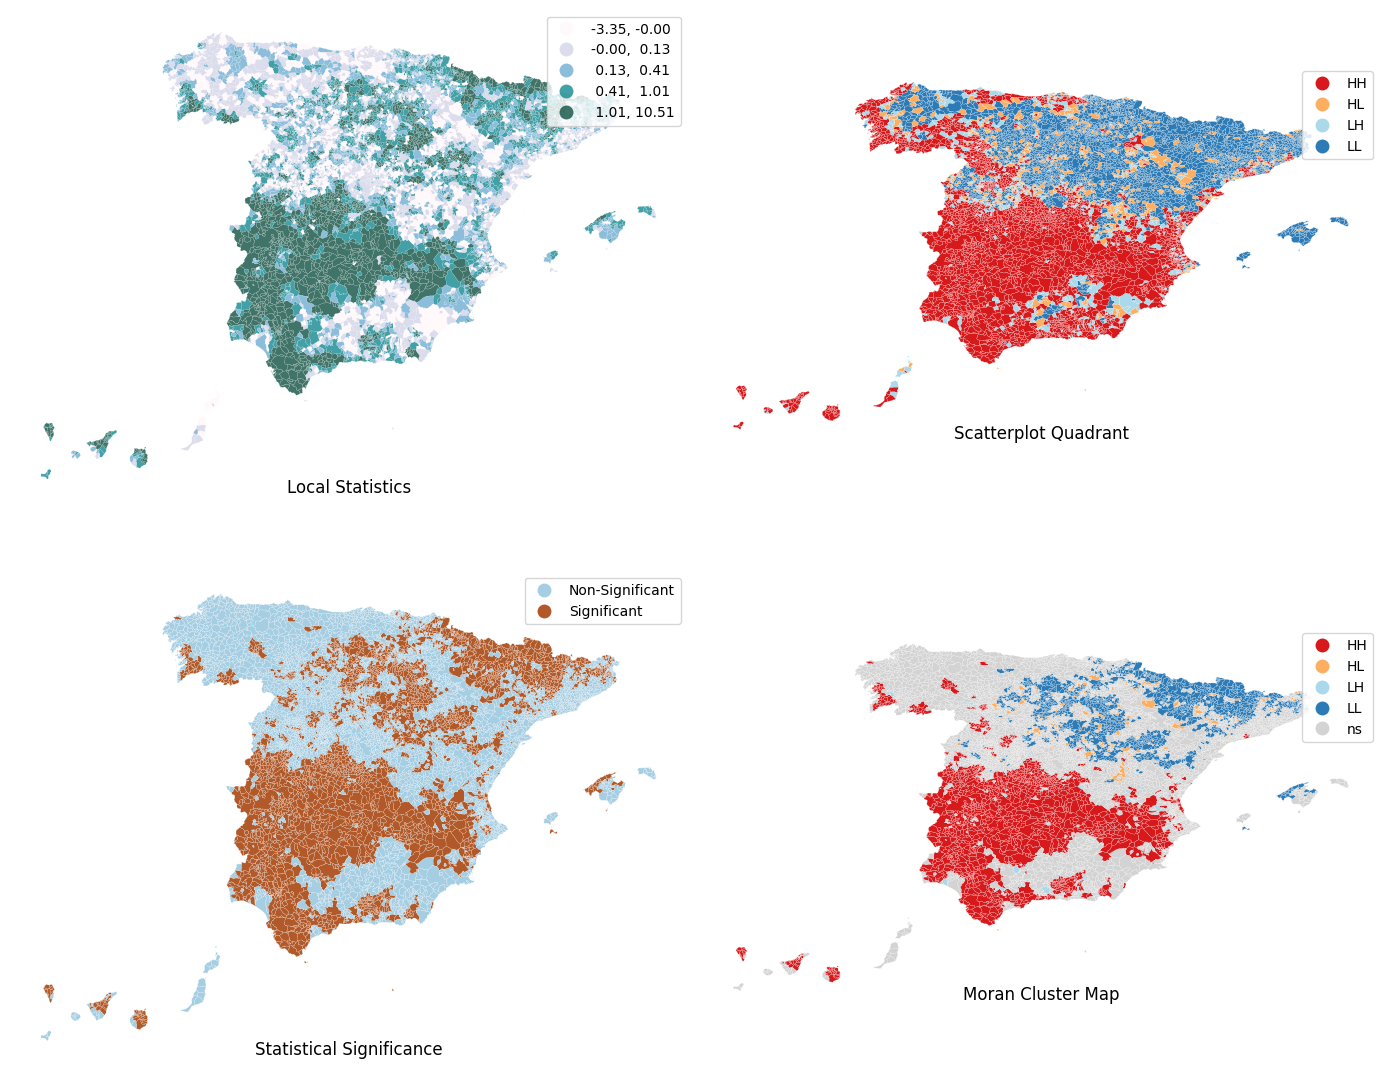

In [64]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdfm.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="PuBuGn",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdfm, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdfm.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
gdfm.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdfm, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

Podemos asignar el cluster LISA (cuadrante y significatividad) como una variable adicional a la cartografía

In [65]:
# Assign pseudo P-values to `gdfm`
gdfm["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
gdfm["sig"] = sig

# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
gdfm["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=gdfm.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
gdfm["labels"].head(20)

0                  LL
1     Non-Significant
2     Non-Significant
3     Non-Significant
4     Non-Significant
5     Non-Significant
6     Non-Significant
7     Non-Significant
8                  LL
9                  LL
10    Non-Significant
11                 LL
12                 LL
13    Non-Significant
14    Non-Significant
15    Non-Significant
16                 LL
17                 LL
18    Non-Significant
19    Non-Significant
Name: labels, dtype: object

In [ ]:
gdfm["labels"].value_counts()

# Regresión Espacial

Comenzamos haciendo una regresión lineal de la Ley de Okun por mínimos cuadrados ordinarios sin tener en cuenta que, com ya hemos visto, la tasa de Paro presenta un alta dependencia o correlación espacial    

$ TasaParo_i = \beta_0 + \beta_1*RentaPc_i + u_i$

In [66]:
#Regresión MCO
m1 = spreg.OLS(
    # Dependent variable
    gdfm[["TASA_PARO"]].values,
    # Independent variables
    gdfm[["RENTPCAP07"]].values,
    # Dependent variable name
    name_y="TASA_PARO",
    # Independent variable name
    name_x=["RENTA_PERCAPITA"]
)

print(m1.summary)



REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   TASA_PARO                Number of Observations:        8108
Mean dependent var  :      0.1079                Number of Variables   :           2
S.D. dependent var  :      0.0557                Degrees of Freedom    :        8106
R-squared           :      0.0024
Adjusted R-squared  :      0.0023
Sum squared residual:      25.118                F-statistic           :     19.3226
Sigma-square        :       0.003                Prob(F-statistic)     :   1.118e-05
S.E. of regression  :       0.056                Log likelihood        :   11915.333
Sigma-square ML     :       0.003                Akaike info criterion :  -23826.665
S.E of regression ML:      0.0557                Schwarz criterion     :  -23812.664

-----------------------------------------------------------------------------

In [67]:
# Create column with residual values from m1
gdfm["residual"] = m1.u

Diagnosis de los residuos ¿Son Ruido blanco?

In [68]:
gdfm["lag_residual"] = weights.spatial_lag.lag_spatial(wq, m1.u)


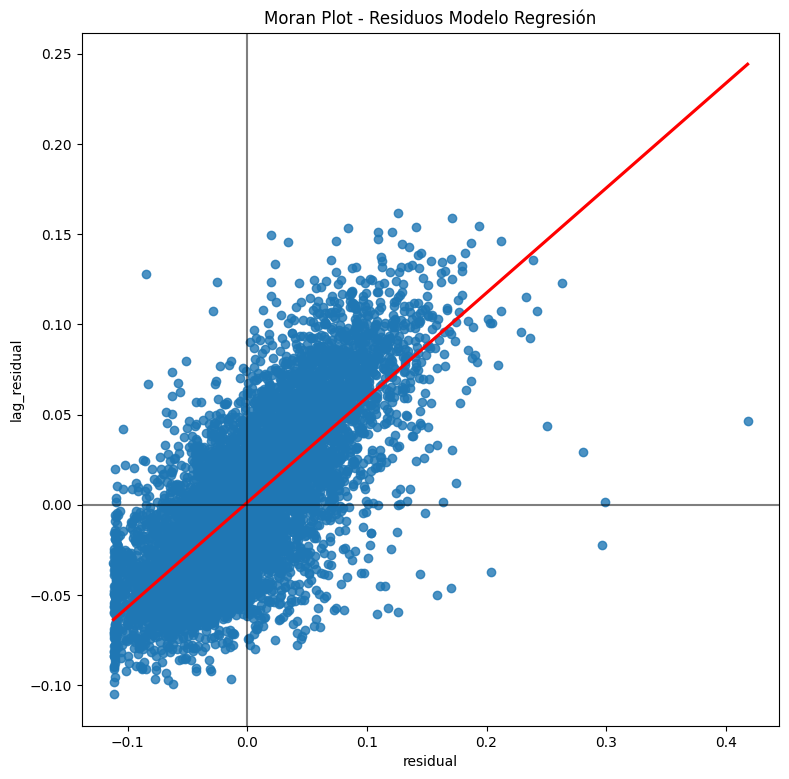

In [69]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(
    x="residual",
    y="lag_residual",
    ci=None,
    data=gdfm,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Residuos Modelo Regresión")
plt.show()

In [70]:
# Correlación Espacial: La I de Moran
moran = esda.moran.Moran(gdfm["residual"], wq)
print("I de moran:", moran.I.round(3))
print("p-valor:", moran.p_sim)

I de moran: 0.581
p-valor: 0.001


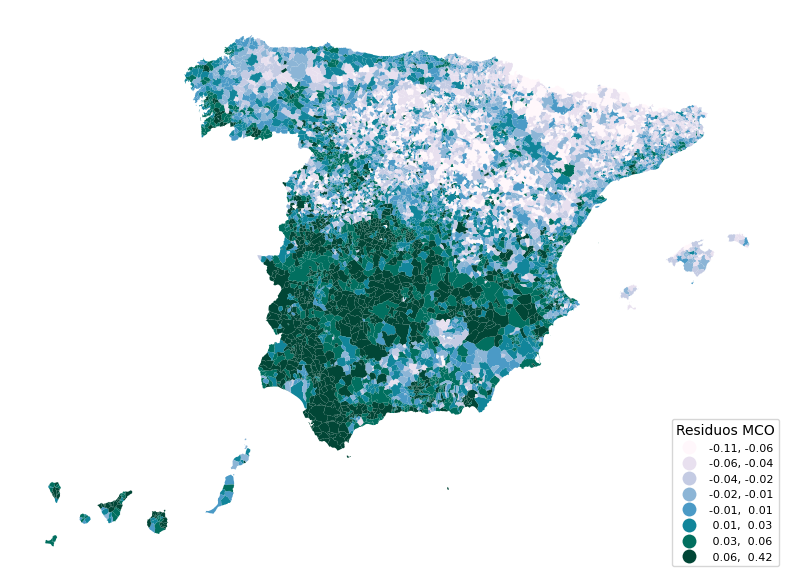

In [71]:
# representación de los residuos MCO  retardada
map=gdfm.plot(column='residual',
         scheme='quantiles',
         k=8, cmap='PuBuGn',
         legend=True,
         figsize=(10,10),
         legend_kwds={'loc': 'lower right', 'fontsize':'8', 'title':'Residuos MCO'}
)
map.set_axis_off()

plt.savefig('Residuos_MCO_Tasa_paro.jpg')

Estimación de un modelo con retardo espacial

In [72]:
# Regresión lag espatial con librería `spreg` y representación de los rsiduos

# (GMM estimation allowing for heteroskedasticity)
mLag = spreg.GM_Error_Het(
    # Dependent variable
    gdfm[["TASA_PARO"]].values,
    # Independent variables
    gdfm[["RENTPCAP07"]].values,
    # Spatial weights matrix
    w=wq,
    # Dependent variable name
    name_y="TASA_PARO",
    # Independent variable name
    name_x=["RENTA_PERCAPITA"],
)

print(mLag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   TASA_PARO                Number of Observations:        8108
Mean dependent var  :      0.1079                Number of Variables   :           2
S.D. dependent var  :      0.0557                Degrees of Freedom    :        8106
Pseudo R-squared    :      0.0024
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.1001526       0.0028346      35.3322351       0.0000000
     RENTA_PERCAPITA       0.0000005       0.0000002       2.5983705       0.00

Diagnosis de los residuos

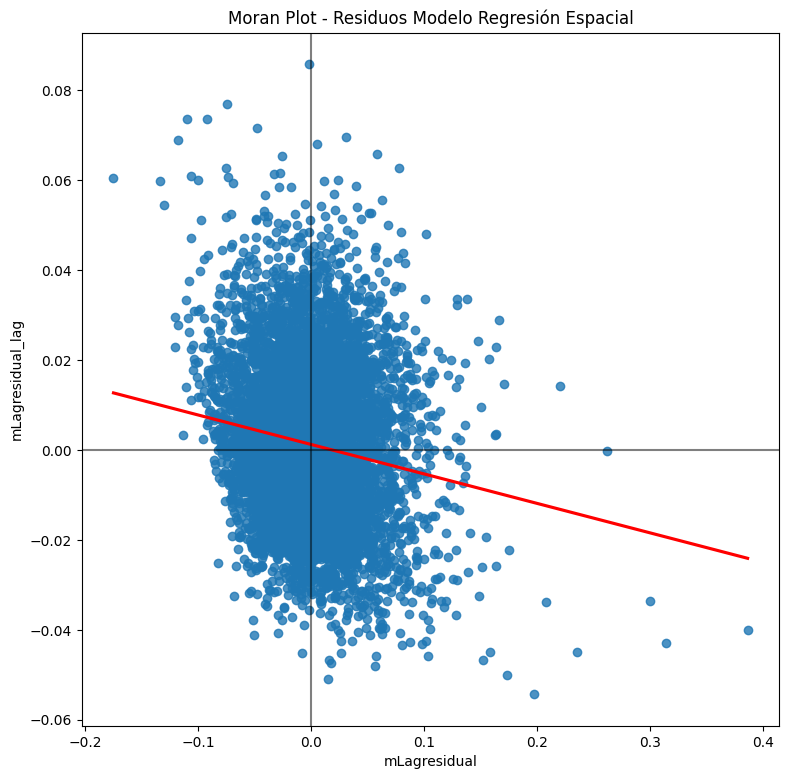

In [73]:
# Create column with residual values from m1
gdfm["mLagresidual"] = mLag.e_filtered
gdfm["mLagresidual_lag"] = weights.spatial_lag.lag_spatial(wq, mLag.e_filtered)

f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(
    x="mLagresidual",
    y="mLagresidual_lag",
    ci=None,
    data=gdfm,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Residuos Modelo Regresión Espacial")
plt.show()


In [74]:
# Correlación Espacial: La I de Moran
moran = esda.moran.Moran(gdfm["mLagresidual"], wq)
print("I de moran:", moran.I.round(3))
print("p-valor:", moran.p_sim)

I de moran: -0.066
p-valor: 0.001


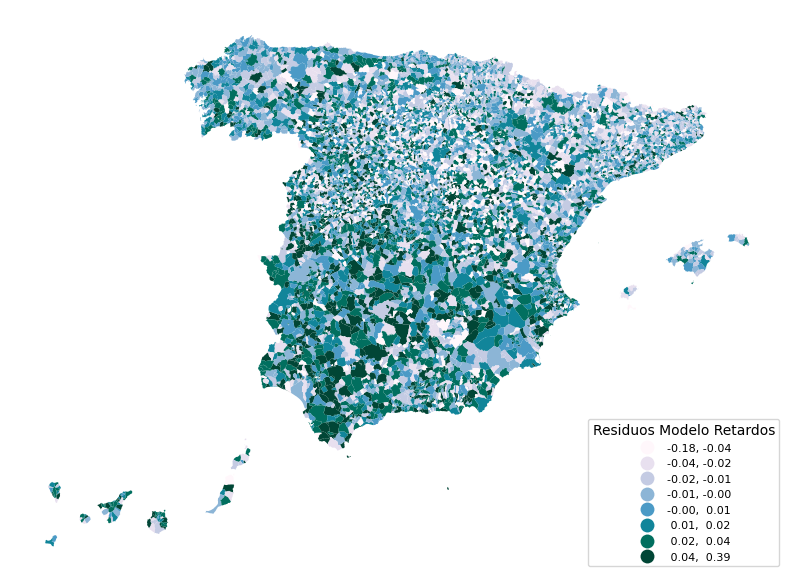

In [75]:
# representación de los residuos Modelo Retardado

map=gdfm.plot(column='mLagresidual',
         scheme='quantiles',
         k=8, cmap='PuBuGn',
         legend=True,
         figsize=(10,10),
         legend_kwds={'loc': 'lower right', 'fontsize':'8', 'title':'Residuos Modelo Retardos'}
)
map.set_axis_off()

#plt.savefig('Residuos_MCO_Tasa_paro.jpg')